In [1]:
# pip install dvc dvc[gdrive] mlflow pandas scikit-learn --q

## Importing the Library

In [17]:
import re
import nltk
import warnings
import nltk
import string
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split


## Load the data

In [2]:
# Load or create raw data
df = pd.read_csv("SMSSpamCollection.csv", delimiter='\t')
df.columns = ['labels', 'Messages']
df

,labels,Messages
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,spam,FreeMsg Hey there darling it's been 3 week's n...
...,...,...
5566,spam,This is the 2nd time we have tried 2 contact u...
5567,ham,Will ü b going to esplanade fr home?
5568,ham,"Pity, * was in mood for that. So...any other s..."
5569,ham,The guy did some bitching but I acted like i'd...


## Exploratory data analysis

In [3]:
df.groupby('labels').describe()

Messages                                                               
          count unique                                                top freq
labels                                                                        
ham        4824   4515                             Sorry, I'll call later   30
spam        747    653  Please call our customer service representativ...    4

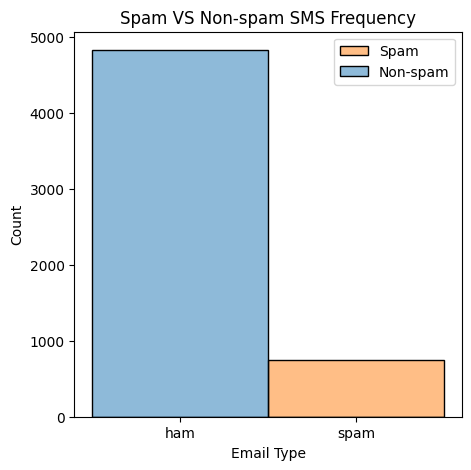

In [4]:
plt.figure(figsize = (5,5))
sns.histplot(data = df, x = 'labels', hue='labels', bins = 2)
plt.xlabel("Email Type")
plt.title("Spam VS Non-spam SMS Frequency")
plt.legend(["Spam","Non-spam"])
plt.show()

array([<Axes: title={'center': 'ham'}>, <Axes: title={'center': 'spam'}>],
      dtype=object)

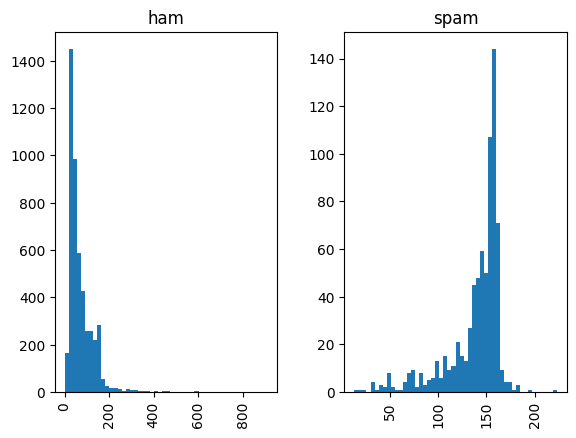

In [5]:
df['length'] = df['Messages'].apply(len)
df.hist(column='length', by='labels', bins = 50)

## Preprocessing the SMS

In [3]:
# cleaning the text
def preprocess_text(text):
    # 1. Case Folding
    text = text.lower()

    # 2. Remove Punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # 3. Tokenization
    tokens = word_tokenize(text)

    # 4. Remove Stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # 5. Remove word of length 1
    tokens = [word for word in tokens if len(word) > 1]

    # 6. Remove Extra Whitespace and join tokens back to string
    cleaned_text = ' '.join(tokens)

    return cleaned_text

In [4]:
# Applying the preprocessing step
df['Messages'] = df['Messages'].apply(preprocess_text)
df.head()

,labels,Messages
0,ham,ok lar joking wif oni
1,spam,free entry wkly comp win fa cup final tkts 21s...
2,ham,dun say early hor already say
3,ham,nah dont think goes usf lives around though
4,spam,freemsg hey darling weeks word back id like fu...


## Function to print the distribution of the labels

In [5]:
def print_class_counts(train_y, val_y, test_y):
    datasets = {
        "Training": train_y,
        "Validation": val_y,
        "Testing": test_y
    }

    for name, labels in datasets.items():
        total = len(labels)
        ham_count = np.sum(labels == 'ham')
        spam_count = np.sum(labels == 'spam')
        
        ham_percentage = (ham_count / total) * 100 if total > 0 else 0
        spam_percentage = (spam_count / total) * 100 if total > 0 else 0
        
        print(f"{name} data:")
        print(f"Number of 'ham' (0): {ham_count} ({ham_percentage:.2f}%)")
        print(f"Number of 'spam' (1): {spam_count} ({spam_percentage:.2f}%)")
        print("\n")


# Implementing DVC

## Initializing DVC

In [7]:
! git init
! dvc init

Initialized empty Git repository in C:/Users/Keshav/Desktop/DS Course/Sem 4/3. AML/Assignment 2/.git/
Initialized DVC repository.

You can now commit the changes to git.

+---------------------------------------------------------------------+
|                                                                     |
|        DVC has enabled anonymous aggregate usage analytics.         |
|     Read the analytics documentation (and how to opt-out) here:     |
|             <https://dvc.org/doc/user-guide/analytics>              |
|                                                                     |
+---------------------------------------------------------------------+

What's next?
------------
- Check out the documentation: <https://dvc.org/doc>
- Get help and share ideas: <https://dvc.org/chat>
- Star us on GitHub: <https://github.com/iterative/dvc>


## Setting up remote storage

In [17]:
!dvc remote add -d storage gdrive://17__887ib2CmCRl6oUD8sxQ8rAJz6W03-
!git status

Setting 'storage' as a default remote.


ERROR: configuration error - config file error: remote 'storage' already exists. Use `-f|--force` to overwrite it.


On branch main
Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	Assignment02.ipynb
	Info.txt
	dvc.json
	test.csv
	train.csv
	val.csv

nothing added to commit but untracked files present (use "git add" to track)


## Configure DVC to use a Service Account

In [11]:
!dvc remote modify storage gdrive_use_service_account true
!dvc remote modify storage gdrive_service_account_json_file_path dvc.json

## Adding version 1 to DVC for tracking

In [7]:
X = df['Messages']
y = df['labels']

# Initial train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

print(f"Train set: {y_train.value_counts()}")
print(f"Validation set: {y_val.value_counts()}")
print(f"Test set: {y_test.value_counts()}")

Train set: labels
ham     3376
spam     523
Name: count, dtype: int64
Validation set: labels
ham     730
spam    106
Name: count, dtype: int64
Test set: labels
ham     718
spam    118
Name: count, dtype: int64


In [8]:
train_data = pd.concat([X_train, y_train], axis=1)
train_data.to_csv('train.csv', index=False)

test_data = pd.concat([X_test, y_test], axis=1)
test_data.to_csv('test.csv', index=False)

val_data = pd.concat([X_val, y_val], axis=1)
val_data.to_csv('val.csv', index=False)

### Distribution of the splitted data with random seed 1

In [18]:
train_y = train_data['labels']
val_y = val_data['labels']
test_y = test_data['labels']
print_class_counts(train_y, val_y, test_y)

Training data:
Number of 'ham' (0): 3376 (86.59%)
Number of 'spam' (1): 523 (13.41%)


Validation data:
Number of 'ham' (0): 730 (87.32%)
Number of 'spam' (1): 106 (12.68%)


Testing data:
Number of 'ham' (0): 718 (85.89%)
Number of 'spam' (1): 118 (14.11%)




### Tracking with DVC

In [19]:
!dvc add SMSSpamCollection.csv train.csv test.csv val.csv


To track the changes with git, run:

	git add val.csv.dvc train.csv.dvc SMSSpamCollection.csv.dvc test.csv.dvc

To enable auto staging, run:

	dvc config core.autostage true


\u280b Checking graph



In [20]:
# !git add train.csv.dvc test.csv.dvc .gitignore val.csv.dvc
!git add SMSSpamCollection.csv.dvc train.csv val.csv.dvc test.csv.dvc .gitignore
!git status
!git commit -m "Version 1 split"

The following paths are ignored by one of your .gitignore files:
train.csv
hint: Use -f if you really want to add them.
hint: Disable this message with "git config advice.addIgnoredFile false"


On branch Main
Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   test.csv.dvc
	modified:   val.csv.dvc

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   .dvc/config
	modified:   train.csv.dvc

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	Assignment02.ipynb
	Info.txt
	dvc.json

[Main eb56552] Version 1 split
 2 files changed, 4 insertions(+), 4 deletions(-)


In [21]:
!dvc push

4 files pushed


## Splitting the data version 2


In [24]:
X = df['Messages']
y = df['labels']

# Initial train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=100)

# Split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=100)

print(f"Train set: {y_train.value_counts()}")
print(f"Validation set: {y_val.value_counts()}")
print(f"Test set: {y_test.value_counts()}")

Train set: labels
ham     3376
spam     523
Name: count, dtype: int64
Validation set: labels
ham     717
spam    119
Name: count, dtype: int64
Test set: labels
ham     731
spam    105
Name: count, dtype: int64


In [25]:
train_data = pd.concat([X_train, y_train], axis=1)
train_data.to_csv('train.csv', index=False)

test_data = pd.concat([X_test, y_test], axis=1)
test_data.to_csv('test.csv', index=False)

val_data = pd.concat([X_val, y_val], axis=1)
val_data.to_csv('val.csv', index=False)

### Distribution of splitted data with seed 100

In [26]:
train_y = train_data['labels']
val_y = val_data['labels']
test_y = test_data['labels']
print_class_counts(train_y, val_y, test_y)

Training data:
Number of 'ham' (0): 3376 (86.59%)
Number of 'spam' (1): 523 (13.41%)


Validation data:
Number of 'ham' (0): 717 (85.77%)
Number of 'spam' (1): 119 (14.23%)


Testing data:
Number of 'ham' (0): 731 (87.44%)
Number of 'spam' (1): 105 (12.56%)




### Trackign with DVC 

In [27]:
!dvc add train.csv test.csv val.csv

\u280b Checking graph




To track the changes with git, run:

	git add train.csv.dvc val.csv.dvc test.csv.dvc

To enable auto staging, run:

	dvc config core.autostage true


In [28]:
# !git add val.csv.dvc test.csv.dvc train.csv.dvc
!git add train.csv val.csv.dvc test.csv.dvc .gitignore
! git status
!git commit -m "Version 2 split"

The following paths are ignored by one of your .gitignore files:
train.csv
hint: Use -f if you really want to add them.
hint: Disable this message with "git config advice.addIgnoredFile false"


On branch Main
Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   test.csv.dvc
	modified:   val.csv.dvc

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   .dvc/config

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	Assignment02.ipynb
	Info.txt
	dvc.json

[Main 20265c3] Version 2 split
 2 files changed, 4 insertions(+), 4 deletions(-)


In [29]:
! dvc push

3 files pushed


## Accessing all data version and printing distribution

In [39]:
! git log

commit 20265c30157037ef88c63c76afaf741c908fbe9f
Author: Big-Marvel <mail.keshev@gmail.com>
Date:   Fri Feb 28 19:21:17 2025 +0530

    Version 2 split

commit eb565527b5a029a3721dfa9113660adf4671a7c1
Author: Big-Marvel <mail.keshev@gmail.com>
Date:   Fri Feb 28 19:16:05 2025 +0530

    Version 1 split

commit 285db9afd56e174639164503a0cc671ed4eda8d9
Author: Big-Marvel <mail.keshev@gmail.com>
Date:   Wed Feb 26 18:06:01 2025 +0530

    Version 2 split

commit bbc1ee389a0e563dd3d3dd8495e31a3843111470
Author: Big-Marvel <mail.keshev@gmail.com>
Date:   Wed Feb 26 18:02:35 2025 +0530

    Version 1 split

commit e3d18ea0b395f19296d7465f4be551ff39ff72c0
Author: Big-Marvel <mail.keshev@gmail.com>
Date:   Tue Feb 25 19:51:34 2025 +0530

    Adding the raw_data.csv

commit bc53d3f918c77956b47e055b44ae02f0e009593c
Author: Big-Marvel <mail.keshev@gmail.com>
Date:   Tue Feb 25 19:51:25 2025 +0530

    Track SMSSpamCollection.csv using DVC


## Returning to version 1

In [40]:
!git checkout eb565527b5a029a3721dfa9113660adf4671a7c1 train.csv.dvc val.csv.dvc test.csv.dvc
!dvc checkout

Updated 2 paths from d94fd8a


M       test.csv
M       val.csv


In [41]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
val = pd.read_csv("val.csv")

In [42]:
test_y = test["labels"]
train_y = train["labels"]
val_y = val["labels"]

In [43]:
import numpy as np
print_class_counts(train_y, val_y, test_y)

Training data:
Number of 'ham' (0): 3376 (86.59%)
Number of 'spam' (1): 523 (13.41%)


Validation data:
Number of 'ham' (0): 730 (87.32%)
Number of 'spam' (1): 106 (12.68%)


Testing data:
Number of 'ham' (0): 718 (85.89%)
Number of 'spam' (1): 118 (14.11%)




## Returning to Version 2

In [44]:
!git checkout 20265c30157037ef88c63c76afaf741c908fbe9f train.csv.dvc val.csv.dvc test.csv.dvc
!dvc checkout

Updated 2 paths from 2f342fd


M       test.csv
M       val.csv


In [48]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
val = pd.read_csv("val.csv")

In [49]:
test_y = test["labels"]
train_y = train["labels"]
val_y = val["labels"]

In [50]:
print_class_counts(train_y, val_y, test_y)

Training data:
Number of 'ham' (0): 3376 (86.59%)
Number of 'spam' (1): 523 (13.41%)


Validation data:
Number of 'ham' (0): 717 (85.77%)
Number of 'spam' (1): 119 (14.23%)


Testing data:
Number of 'ham' (0): 731 (87.44%)
Number of 'spam' (1): 105 (12.56%)


